## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import math

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from sklearn.model_selection import train_test_split
import sklearn.model_selection as skl
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, average_precision_score
from random import sample

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True         # to log device placement
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications import DenseNet121
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060 SUPER, pci bus id: 0000:08:00.0, compute capability: 7.5

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15398153312713942935
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16488258916979135299
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 988587005408954116
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7356237760
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13724105454715276179
physical_device_desc: "device: 0, name: GeForce RTX 2060 SUPER, pci bus id: 0000:08:00.0, compute ca

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('../../data/pneumonia_data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('../../data/pneumonia_data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
3528,00000955_002.png,Atelectasis,2,955,32,F,PA,2048,2500,0.171,0.171,NaN,../../data/pneumonia_data/images_001/images/00...
63069,00015594_000.png,No Finding,0,15594,60,M,PA,2770,2991,0.143,0.143,NaN,../../data/pneumonia_data/images_007/images/00...
21216,00005670_000.png,No Finding,0,5670,45,F,PA,2048,2500,0.168,0.168,NaN,../../data/pneumonia_data/images_003/images/00...


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
all_xray_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_xray_labels = [x for x in all_xray_labels if len(x)>0]
print("Number of labels: {}\nLabels: {}".format(len(all_xray_labels),", ".join(all_xray_labels)))

for label in all_xray_labels:
    if len(label)>1: # leave out empty labels
        all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)

all_xray_df.sample(3)

Number of labels: 15
Labels: Atelectasis, Cardiomegaly, Consolidation, Edema, Effusion, Emphysema, Fibrosis, Hernia, Infiltration, Mass, No Finding, Nodule, Pleural_Thickening, Pneumonia, Pneumothorax


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
71203,00017552_000.png,No Finding,0,17552,27,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
65759,00016233_000.png,Effusion|Infiltration,0,16233,67,M,PA,2992,2897,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
111196,00030358_000.png,No Finding,0,30358,49,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df["pneumonia_class"] = all_xray_df["Pneumonia"].map(lambda pneumonia: "yes" if pneumonia == 1.0 else "no")
all_xray_df["pneumonia_class"] = all_xray_df["pneumonia_class"].astype(str)
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
54061,00013616_001.png,No Finding,1,13616,60,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
93751,00023620_000.png,No Finding,0,23620,41,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
99871,00026451_045.png,Pneumothorax,45,26451,51,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,no


## Create your training and testing data:

In [5]:
def create_splits(df, test_size=0.2):
    train_df, valid_df = train_test_split(df, test_size=test_size, stratify=df['Pneumonia'])
    
    p_inds = train_df[train_df.Pneumonia==1].index.tolist()
    np_inds = train_df[train_df.Pneumonia==0].index.tolist()
    np_sample = sample(np_inds,len(p_inds))
    train_df = train_df.loc[p_inds + np_sample]


    p_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
    np_inds = valid_df[valid_df.Pneumonia==0].index.tolist()
    np_sample = sample(np_inds,3*len(p_inds))
    valid_df = valid_df.loc[p_inds + np_sample]

    return train_df, valid_df

train_df, valid_df = create_splits(all_xray_df)
train_df.shape, valid_df.shape

((2290, 29), (1144, 29))

In [6]:
# check class balance for training set
print('Number of pneumonia cases: {}'.format(len(train_df[train_df.Pneumonia==1.0])))
print('Number of non-pneumonia cases: {}'.format(len(train_df[train_df.Pneumonia==0.0])))
print('Percentage of pneumonia cases in train set {:0.4f}'.format(train_df['Pneumonia'].sum()/len(train_df)))

Number of pneumonia cases: 1145
Number of non-pneumonia cases: 1145
Percentage of pneumonia cases in train set 0.5000


In [7]:
# check class balance for validation set
print('Number of pneumonia cases: {}'.format(len(valid_df[valid_df.Pneumonia==1.0])))
print('Number of non-pneumonia cases: {}'.format(len(valid_df[valid_df.Pneumonia==0.0])))
print('Percentage of pneumonia cases in valid set {:0.4f}'.format(valid_df['Pneumonia'].sum()/len(valid_df)))

Number of pneumonia cases: 286
Number of non-pneumonia cases: 858
Percentage of pneumonia cases in valid set 0.2500


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [8]:
def image_augmentation(rescale_only = False):
    # for validation data
    if rescale_only:
        idg = ImageDataGenerator(rescale=1. / 255.0)
    
    # for training data
    else:
        idg = ImageDataGenerator(rescale=1. / 255.0,
                                  horizontal_flip = True, 
                                  vertical_flip = False, 
                                  height_shift_range= 0.1, 
                                  width_shift_range=0.1, 
                                  rotation_range=20, 
                                  shear_range = 0.1,
                                  zoom_range=0.1)
    return idg

In [9]:
def make_train_gen(idg, train_df, x_col='path', y_col='pneumonia_class', target_size=(224, 224), batch_size=32):
    
    ## Create the actual generators using the output of image_augmentation for our training data
        
    train_gen = idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = x_col,
                                         y_col = y_col,
                                         class_mode = 'binary',
                                         target_size = target_size, 
                                         batch_size = batch_size
                                         )

    return train_gen

In [10]:
def make_val_gen(idg, val_df, x_col='path', y_col='pneumonia_class', target_size=(224, 224), batch_size=512):
    
    val_gen = idg.flow_from_dataframe(dataframe=val_df, 
                                             directory=None, 
                                             x_col = x_col,
                                             y_col = y_col,
                                             class_mode = 'binary',
                                             target_size = target_size, 
                                             batch_size = batch_size
                                             )
    return val_gen

In [11]:
train_idg = image_augmentation()
train_gen = make_train_gen(train_idg, train_df)

val_idg = image_augmentation(rescale_only=True)
val_gen = make_val_gen(val_idg, valid_df)

Found 2290 validated image filenames belonging to 2 classes.
Found 1144 validated image filenames belonging to 2 classes.


In [12]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

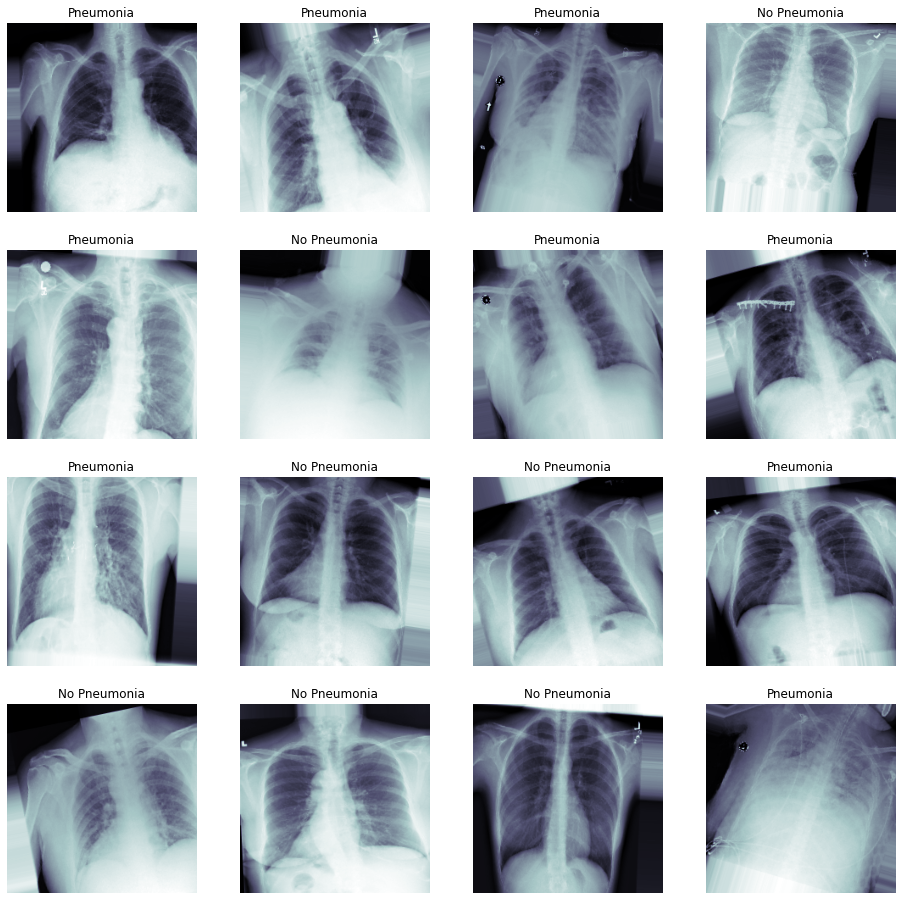

In [13]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [14]:
def load_pretrained_model():

    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    return vgg_model

vgg_model = load_pretrained_model()
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [16]:
def build_model():
    
    model = Sequential()
    model.add(vgg_model)
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(rate=1- 0.7))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(rate = 1-0.7))
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model
model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [17]:
model_path = "model.json"
weight_path = "{}_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='auto', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'auto', 
                      patience=10)

def step_decay(epoch):
    initial_lrate = 1e-4
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

callbacks_list = [checkpoint, early, LearningRateScheduler(step_decay, verbose=1)]

### Start training! 

In [ ]:
optimizer = Adam(lr=1e-4) 
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 40, 
                          callbacks = callbacks_list)

Epoch 1/40

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.


##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [ ]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model.load_weights(weight_path)
pred_Y = model.predict(valX, batch_size = 32, verbose = True)

In [ ]:
def plot_auc(t_y, p_y):
    fpr, tpr, _ = roc_curve(t_y, p_y)
    auc = roc_auc_score(t_y, p_y)
    
    plt.plot(fpr, tpr, label='Pneumonia (AUC: {:.3f})'.format(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title("AUC Curve")
    plt.legend(['Pneumonia (AUC: {:.3f})'.format(auc)], loc='lower right')
    plt.show()
    return

plot_auc(valY, pred_Y)

In [ ]:
def plot_history(history):
    
    N = len(history.history["loss"])
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1)
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (Avr Precision Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Precision')
    c_ax.set_ylabel('Recall')

    return precision, recall, thresholds
    

precision, recall, thresholds = plot_pr(valY, pred_Y)

In [ ]:
precision = np.array(precision)
recall = np.array(recall)
f1_score = 2 * (precision*recall)/(precision+recall)

def plot_score_thresholds(precision, recall, f1_score, thresholds):
    plt.plot(thresholds, precision, label='Precision')
    plt.plot(thresholds, recall, label ='Recall')
    plt.plot(thresholds, f1_score, label = 'F1 score')
    plt.xlabel('Thresholds')
    plt.ylabel('Precision / Recall / F1')
    plt.title("Precision / Recall / F1 and Thresholds")
    plt.legend(['Precision', 'Recall', 'F1 score'], loc='upper right')
    plt.show()
plot_score_thresholds(precision[:-1], recall[:-1], f1_score[:-1], thresholds)

In [ ]:
print("Max F1 score: {}".format(max(f1_score)))

def calc_f1(t_y, p_y):
    prec, recall, thresholds = precision_recall_curve(t_y, p_y)
    return 2*(prec*recall)/(prec+recall), prec, recall, thresholds

f1, prec, recall, thresholds = calc_f1(valY, pred_Y)

metric_df = pd.DataFrame({'f1':f1[:-1], 'prec':prec[:-1], 'recall':recall[:-1], 'thresholds':thresholds})

threshold = metric_df.iloc[metric_df['f1'].idxmax()]['thresholds']
print('threshold corresponding to max f1:', threshold)

In [ ]:
testX, testY = val_gen.next()

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(testX[0:100], testY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open(model_path, "w") as json_file:
    json_file.write(model_json)